In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability.python.distributions as tfd

Three archetypes are defined on a two dimensional space.

In [16]:
archetypes_init = np.array([[1,0],
                  [2,2],
                  [0,1]])

In [17]:
def generate_data (archs, n_points, noise=0.1):
    
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    Y0=np.linalg.norm(data-archs[0],axis=1)
    Y1=np.linalg.norm(data-archs[1],axis=1)
    Y2=np.linalg.norm(data-archs[2],axis=1)
    Y0=Y0/np.max(Y0)
    Y1=Y1/np.max(Y1)
    Y2=Y2/np.max(Y2)
    Y=np.concatenate((np.expand_dims(Y0,axis=1),np.expand_dims(Y1,axis=1),np.expand_dims(Y2,axis=1)),axis=1)
    
    return data, Y

Data is generated as a linear combination of the archetypes. Constrains on the weights are added so as to ensure that the generated data set is a convex mixture of the archetypes. Noise is then added, hence the resulting points can be defined outside the convex hull. Each data point has associated a side information vector  $\vec{Y}=(Y_0,Y_1,Y_2)$, where each component is the distance from one of the archetypes. Side information can be generalised to more complex functions. In the figure below we can see the three archetypes in blue, and the data set in different shades of red. Colors are obtained from the side information, that is used as entry for a RGB  color model.

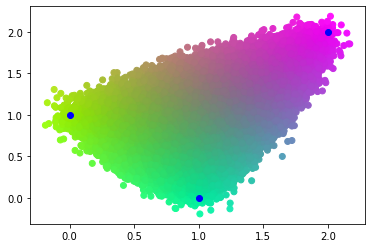

In [18]:
x_train, y_train = generate_data (archetypes_init,100000,noise=0.1)
x_test, y_test = generate_data (archetypes_init,1000,noise=0.1)

data0,data1 = x_train.T
plt.scatter(data0, data1, color=y_train)
data0,data1 = archetypes_init.T
plt.scatter(data0, data1, color='blue')


In [19]:
def get_zfixed ( dim_latent_space ):
    
    z_fixed_t = np.zeros([dim_latent_space, dim_latent_space + 1])

    for k in range(0, dim_latent_space):
        s = 0.0
        for i in range(0, k):
            s = s + z_fixed_t[i, k] ** 2
  
        z_fixed_t[k, k] = np.sqrt(1.0 - s)

        for j in range(k + 1, dim_latent_space + 1):
            s = 0.0
            for i in range(0, k):
                s = s + z_fixed_t[i, k] * z_fixed_t[i, j]

            z_fixed_t[k, j] = (-1.0 / float(dim_latent_space) - s) / z_fixed_t[k, k]
            z_fixed = np.transpose(z_fixed_t)
                    
    return z_fixed


We use variational autoencoders to map the data set into a latent space. The neural network is constructed to force data in latent space to be defined within an arbitrary convex hull. We use a triangular convex hull as shown below. 

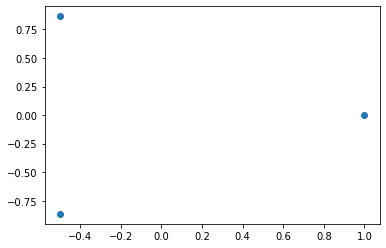

In [20]:
zfixed = get_zfixed (2)
data0,data1 = zfixed.T
plt.scatter(data0, data1)

We construct a variational autoencoder that generates a mean $\mu$, and a standard deviation $\sigma$ for each data point. The point is then mapped into the latent space with a stochastic extraction from a Gaussian $\mathcal{N}(\mu,\,\sigma^{2})$, where $\mu$'s are by construction within a hull $z_{fixed}$. 

In [21]:
original_dim = x_train.shape [1]
sideinfo_dim = y_train.shape [1]

x_train = np.array(np.reshape(x_train, [-1, original_dim]), dtype='float32')
x_test = np.array(np.reshape(x_test, [-1, original_dim]), dtype='float32')
y_train = np.array(np.reshape(y_train, [-1, sideinfo_dim]), dtype='float32')
y_test = np.array(np.reshape(y_test, [-1, sideinfo_dim]), dtype='float32')


# network parameters
intermediate_dim = 4
batch_size = 1024
latent_dim = 2
simplex_vrtxs = latent_dim + 1
epochs = 100



# encoder
input_x = tfk.Input(shape=(original_dim,), name='encoder_input_x', dtype='float32')

x = tfkl.Dense(intermediate_dim, activation='relu')(input_x)
x = tfkl.Dense(intermediate_dim, activation='relu')(x)
A = tfkl.Dense (simplex_vrtxs, activation='linear')(x)
A = tfkl.Dense (simplex_vrtxs, activation=tf.nn.softmax)(A)
B_t = tfkl.Dense (simplex_vrtxs, activation='linear')(x)
B = tf.nn.softmax(tf.transpose(B_t), axis=1)

z_fixed = get_zfixed (latent_dim)
z_fixed = tf.constant (z_fixed, dtype='float32')
mu = tf.matmul(A, z_fixed)
z_pred = tf.matmul(B,mu)
sigma = tfkl.Dense(latent_dim)(x)
t = tfd.Normal(mu,sigma)

input_y = tfk.Input(shape=(sideinfo_dim,), name='encoder_input_y', dtype='float32')
y = tf.identity(input_y)

encoder = tfk.Model([input_x,input_y], [t.sample(),mu,sigma, tf.transpose(B) ,y], name='encoder')
encoder.summary()



# decoder
latent_inputs = tfk.Input(shape=(latent_dim,), name='z_sampling')
input_y_lat = tfk.Input(shape=(sideinfo_dim,), name='encoder_input_y_lat')

x = tfkl.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = tfkl.Dense(original_dim, activation='linear')(x)
x_hat = tfkl.Dense(original_dim, activation='linear')(x)

y = tfkl.Dense(intermediate_dim, activation='relu')(latent_inputs)
y = tfkl.Dense(intermediate_dim, activation='relu')(y)
y_hat = tfkl.Dense(sideinfo_dim, activation='linear')(y) 

decoder = tfk.Model([latent_inputs,input_y_lat], [x_hat,y_hat], name='decoder')
decoder.summary()



# VAE
encoded = encoder([input_x,input_y])
outputs = decoder( [encoded[0],encoded[-1]])
vae = tfk.Model([input_x,input_y], outputs, name='vae')

reconstruction_loss = tfk.losses.mse (input_x, outputs[0])
class_loss = tfk.losses.mse ( input_y, outputs[1])
archetype_loss = tf.reduce_sum( tfk.losses.mse(z_fixed, z_pred))

kl_loss = 1 + sigma - tf.square(mu) - tf.exp(sigma)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5

lambda_p = 1
nu_p = 1

vae_loss = tf.reduce_mean(nu_p*reconstruction_loss + lambda_p*class_loss + kl_loss + archetype_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()


vae.fit([x_train,y_train],  
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test,y_test],None))



# archetypes
archetypes,_ = decoder ([z_pred, tf.zeros([3,3])])
get_archtypes = tfk.Model (input_x, [archetypes,z_pred] , name='get_zpred')


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 4)            12          encoder_input_x[0][0]            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 4)            20          dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 3)            15          dense_13[0][0]                   
____________________________________________________________________________________________

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, 2)]          0                                            
__________________________________________________________________________________________________
encoder_input_y (InputLayer)    [(None, 3)]          0                                            
__________________________________________________________________________________________________
encoder (Model)                 multiple             84          encoder_input_x[0][0]            
                                                                 encoder_input_y[0][0]            
__________________________________________________________________________________________________
decoder (Model)                 [(None, 2), (None, 3 75          encoder[1][0]                  

100000/100000 [==============================] - 1s 9us/sample - loss: 2.3661 - val_loss: 2.0134
Epoch 2/100
100000/100000 [==============================] - 0s 2us/sample - loss: 1.7636 - val_loss: 1.6485
Epoch 3/100
100000/100000 [==============================] - 0s 2us/sample - loss: 1.5743 - val_loss: 1.5525
Epoch 4/100
100000/100000 [==============================] - 0s 2us/sample - loss: 1.5190 - val_loss: 1.4949
Epoch 5/100
100000/100000 [==============================] - 0s 2us/sample - loss: 1.3909 - val_loss: 1.2659
Epoch 6/100
100000/100000 [==============================] - 0s 2us/sample - loss: 1.1090 - val_loss: 1.0143
Epoch 7/100
100000/100000 [==============================] - 0s 3us/sample - loss: 0.9332 - val_loss: 0.8866
Epoch 8/100
100000/100000 [==============================] - 0s 3us/sample - loss: 0.7650 - val_loss: 0.6541
Epoch 9/100
100000/100000 [==============================] - 0s 3us/sample - loss: 0.5478 - val_loss: 0.4958
Epoch 10/100
100000/100000 [===

100000/100000 [==============================] - 0s 2us/sample - loss: 0.2450 - val_loss: 0.2478
Epoch 76/100
100000/100000 [==============================] - 0s 2us/sample - loss: 0.2434 - val_loss: 0.2460
Epoch 77/100
100000/100000 [==============================] - 0s 2us/sample - loss: 0.2425 - val_loss: 0.2463
Epoch 78/100
100000/100000 [==============================] - 0s 3us/sample - loss: 0.2443 - val_loss: 0.2488
Epoch 79/100
100000/100000 [==============================] - 0s 2us/sample - loss: 0.2433 - val_loss: 0.2478
Epoch 80/100
100000/100000 [==============================] - 0s 2us/sample - loss: 0.2427 - val_loss: 0.2463
Epoch 81/100
100000/100000 [==============================] - 0s 2us/sample - loss: 0.2419 - val_loss: 0.2467
Epoch 82/100
100000/100000 [==============================] - 0s 3us/sample - loss: 0.2421 - val_loss: 0.2453
Epoch 83/100
100000/100000 [==============================] - 0s 2us/sample - loss: 0.2439 - val_loss: 0.2466
Epoch 84/100
100000/100

In [22]:
t,mu,sigma, B_t, y = encoder.predict([x_train,np.zeros(np.shape(y_train))])
archetypes_pred, z_pred = get_archtypes(x_train)

$\mu$'s are generated within an arbitrary triangular hull. Below we see the $\mu$'s in latent space in blue, and the vertexes of the arbitrarily chosen hull in orange.

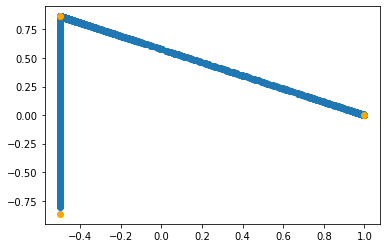

In [23]:
dataX,dataY = mu.T
plt.scatter(dataX,dataY)
zfixed = get_zfixed (2)
data0,data1 = zfixed.T
plt.scatter(data0, data1,color='orange')

Using the data points initially generated we are able to reconstruct the initial points that have been taken as archetypes. Below, we see in blue the archetypes initailly defined, and in orange the predicted ones.

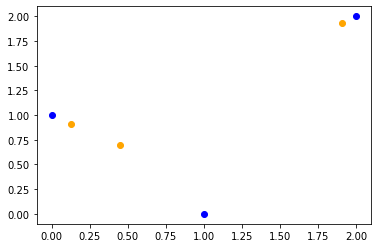

In [24]:
dataX,dataY = archetypes_init.T
plt.scatter(dataX,dataY,color='blue')

dataX,dataY = np.array(archetypes_pred).T
plt.scatter(dataX,dataY,color='orange')


We can feed the trained network with some test data and see that is able to reconstruct the data and side information after mapping into latent space.

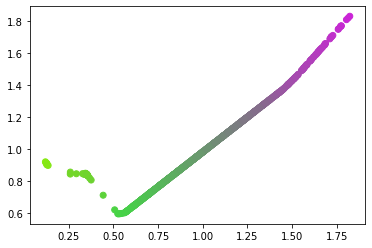

In [25]:
t, y_pred = vae.predict([x_test,np.zeros(np.shape(y_test))])
dataX,dataY = t.T

if (np.min(y_pred)<0):
    y_pred += np.abs(np.min(y_pred))
if (np.min(y_pred)>1):
    y_pred /= np.abs(np.max(y_pred))

plt.scatter(dataX,dataY,color=y_pred)

Below we can see the original test data. If we compare the original data with the results of the variational encoder above, we can see that the encoder has the effect of a regularizer, i.e. the resulting effect is that noise is removed and data lie within the convex hull.

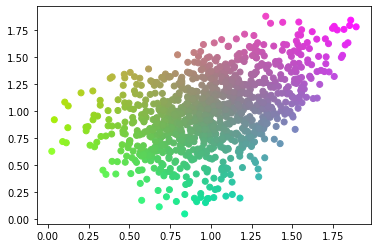

In [27]:
dataX,dataY = x_test.T
plt.scatter(dataX,dataY,color=y_test)